In [1]:
import pandas as pd
import numpy as np
import sys

sys.path.insert(0, '../visualize/')
sys.path.insert(0, '../models/')
sys.path.insert(0, '../features/')

from tcors_functions import *
from build_features import *
from counterprop import *
from linear_regression import *
from visualize import *

random_state = 42

bin_step = 0.25

Prepare Data

In [2]:
build_features(step = bin_step)

In [3]:
df = load_features('model_features.pkl')
df.head()

,screen_id,week,project,site,dose,screen_sex,screen_age,carmine_nicotine,prp_change,prp_change_bin,prp_change_bin_label
37,J-A003,week12,project 1,uvm,15.8,Female,32,16.7,0.487500,"(0.25, 0.5]",5
50,J-A004,week12,project 1,uvm,0.4,Female,38,15.9,0.725225,"(0.5, 0.75]",6
76,J-A007,week12,project 1,uvm,15.8,Female,44,16.2,0.971223,"(0.75, 1.0]",7
89,J-A010,week12,project 1,uvm,15.8,Female,28,15.8,0.895522,"(0.75, 1.0]",7
117,J-A015,week12,project 1,uvm,15.8,Female,25,16.9,1.315152,"(1.25, 1.5]",9


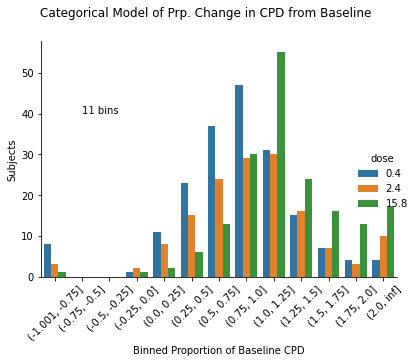

In [4]:
 plot_bins(df)
 plt.tight_layout()
 plt.savefig("../../reports/figures/prp_change.png", dpi = 300)

In [5]:
cat_targets = ['prp_change_bin_label']
num_targets = ['prp_change']
cat_predictors = ['project', 'site', 'dose', 'screen_sex']
num_predictors = ['screen_age', 'carmine_nicotine']

X = df[cat_predictors + num_predictors]
y = df[cat_targets + num_targets]

X_without_nic = X.copy()
X_without_nic.drop(['carmine_nicotine'], axis=1)

num_predictors_withoutnic = num_predictors[:]
num_predictors_withoutnic.remove('carmine_nicotine')


## Linear Regression

In [6]:
without_nic = fit_linear(
    X_without_nic,
    y[['prp_change']],
    num_predictors_withoutnic,
    cat_predictors,
    bin_step = bin_step,
    random_state=random_state
)

with_nic = fit_linear(
    X,
    y[['prp_change']],
    num_predictors,
    cat_predictors,
    bin_step = bin_step,
    random_state=random_state
)

Performance when treated as a regression

In [7]:
wo_nic_avg = without_nic.avg_scores
wo_nic_avg['label'] = 'without_nic'

w_nic_avg = with_nic.avg_scores
w_nic_avg['label'] = 'with_nic'

lm_r2 = pd.concat([wo_nic_avg, w_nic_avg])
lm_r2['model'] = 'linear_model'

lm_r2

,mean_cv_r2,sd_cv_r2,test_r2,label,model
1,0.096670,0.083564,0.155133,without_nic,linear_model
1,0.084482,0.085027,0.138708,with_nic,linear_model


Performance when treated as a classifier

In [8]:
lm_f1 = pd.DataFrame(
    {
        "f1" : [without_nic.clf_mets, with_nic.clf_mets],
        "label" : ["without_nic", "with_nic"],
        "model" : ['linear_model*', 'linear_model*']
    }
)
lm_f1


,f1,label,model
0,0.165049,without_nic,linear_model*
1,0.174757,with_nic,linear_model*


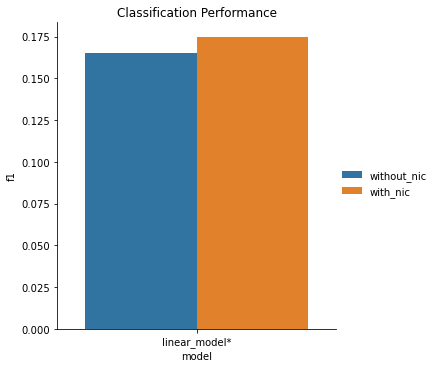

In [9]:
clf_plt(lm_f1)

## Counter-Propagation  

In [ ]:
# retain exact splits used in linear model above

nic_split = {
    X_train: with_nic.X_train,
    X_test: with_nic.X_test,
    y_train: with_nic.y_train,
    y_test: with_nic.y_test
}

nonic_split = {
    X_train: without_nic.X_train,
    X_test: without_nic.X_test,
    y_train: without_nic.y_train,
    y_test: without_nic.y_test
}